In [168]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchaudio
import scipy
import torch
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import tqdm
from scipy import signal
from utils import Unflatten

from ipywidgets import interactive
from IPython.display import Audio, display

## CinC2020 Dataset

In [92]:
from datasets import CinC2020

In [93]:
ds = CinC2020(set_seq_len=5000, fs=500, clean_signal=True)
p_signal, sampling_rate, age, sex, dx = ds[0]
p_signal, sampling_rate, age, sex, dx

(array([[ 0.00023028,  0.0015427 ,  0.00132405, ...,  0.01512091,
         -0.00923978, -0.00637499],
        [ 0.000211  ,  0.00056434,  0.00040496, ...,  0.02023743,
         -0.00940781, -0.0072829 ],
        [ 0.00019173, -0.00042402, -0.00053412, ...,  0.02484411,
         -0.00953574, -0.00814077],
        ...,
        [-0.01050244, -0.01771826, -0.00795653, ..., -0.0322378 ,
         -0.0084096 ,  0.00053057],
        [-0.00995213, -0.01562813, -0.00627436, ..., -0.02894913,
         -0.00722838,  0.00120927],
        [-0.00947202, -0.01347868, -0.00444271, ..., -0.02532123,
         -0.00600689,  0.00196797]], dtype=float32),
 500,
 53.0,
 0.0,
 164867002)

In [94]:
# display(Audio(data=p_signal[:,0], rate=sampling_rate))
iter_ds = iter(ds)

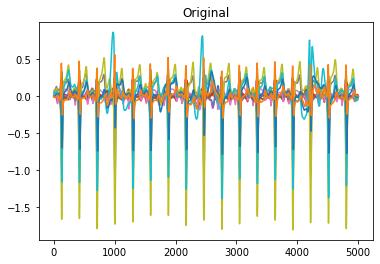

In [95]:
p_signal, sampling_rate, age, sex, dx = next(iter_ds)
# while np.max(p_signal) < 10:
#     p_signal, sampling_rate, age, sex, dx = next(iter_ds)

plt.figure()
plt.title(f"Original")
plt.plot(p_signal)
plt.show()

specgram.shape torch.Size([12, 26, 201])


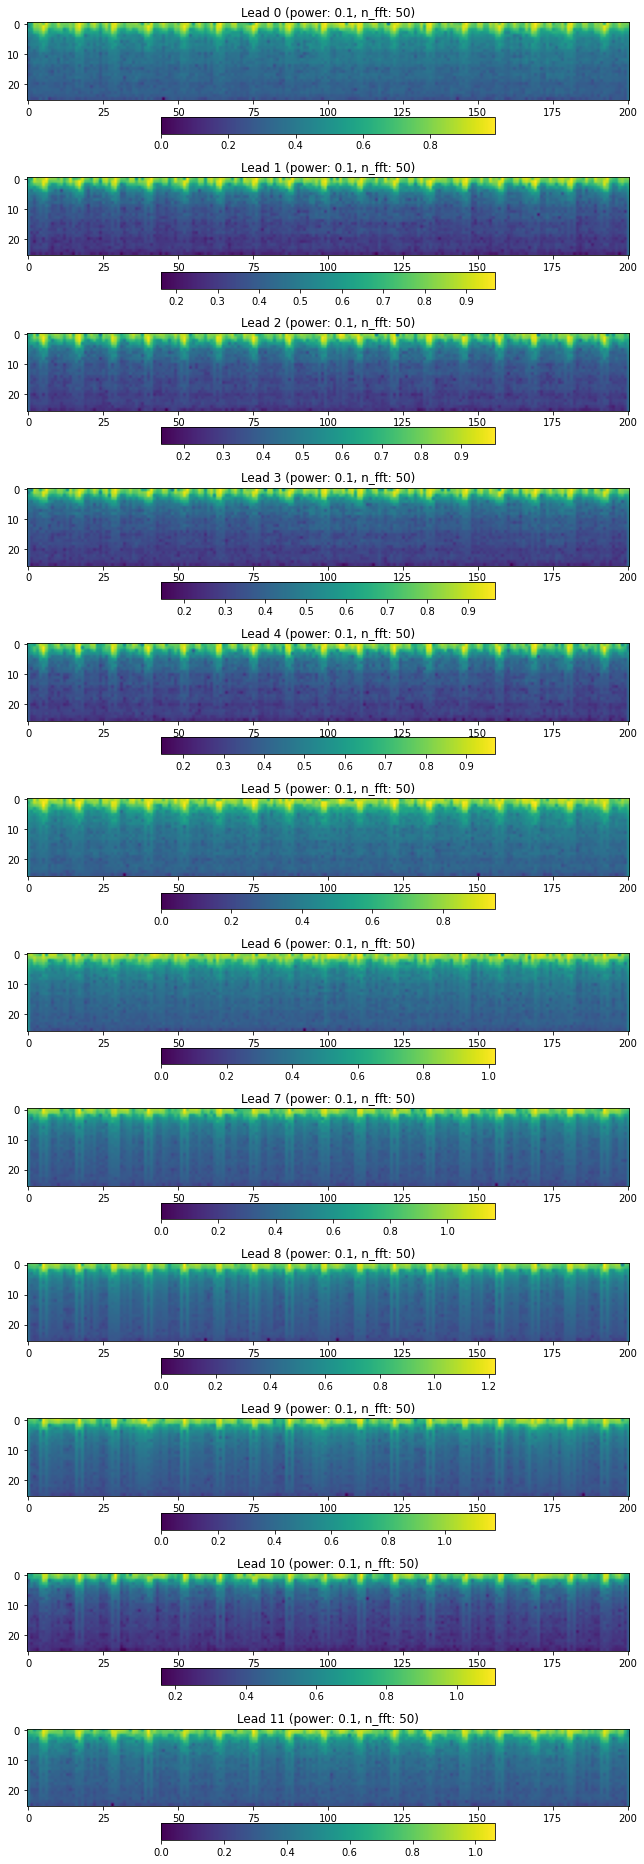

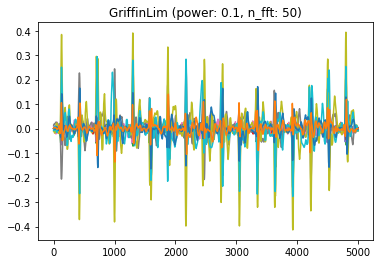

In [96]:
n_fft = 50

# power
power = 0.1

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    n = torchaudio.transforms.Spectrogram(
        n_fft = n_fft,
        power = power,
        normalized=True
    )
    specgram = n(torch.Tensor(p_signal.T))
    print("specgram.shape", specgram.shape)
    rn = torchaudio.transforms.GriffinLim(n_fft = n_fft, power = power)
    recon = rn(specgram)


fig, axs = plt.subplots(12, 1, figsize=(10, 26))
# plt.imshow(specgram[0,:,:].log2().numpy())
for i in range(12):
    axs[i].set_title(f"Lead {i} (power: {power}, n_fft: {n_fft})")
    pcm = axs[i].imshow(specgram[i,:,:].numpy())
    fig.colorbar(pcm, orientation="horizontal", ax=axs[i])
#     axs[i].colorbar()
fig.tight_layout()
plt.show()

plt.figure()
plt.title(f"GriffinLim (power: {power}, n_fft: {n_fft})")
plt.plot(recon.T)
plt.show()

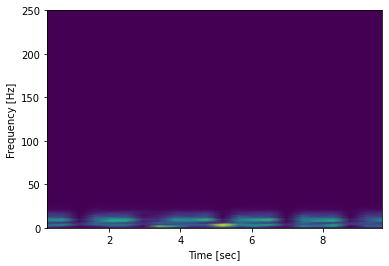

In [97]:
f, t, Sxx =signal.spectrogram(p_signal[:, 0], fs=sampling_rate)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## Debugging NN Architecture

In [98]:
p_signal, sampling_rate, age, sex, dx = next(iter(DataLoader(ds, batch_size=3)))

p_signal.shape, sampling_rate, age, sex, dx

(torch.Size([3, 5000, 12]),
 tensor([500, 500, 500]),
 tensor([53., 70., 70.], dtype=torch.float64),
 tensor([0., 1., 1.], dtype=torch.float64),
 tensor([164867002, 164861001, 164861001]))

In [181]:
x = torch.transpose(p_signal, 1, 2)
n_fft = 50
power = 0.1

enc = nn.Sequential(
    # torch.Size([b, 12, 26, 201])
    nn.Conv2d(
        in_channels=12, out_channels=24, kernel_size=(26, 3),
        stride=2, padding=0, groups=1
    ),
    nn.Softplus(),
    # torch.Size([b, 24, 1, 100])
    nn.Flatten(2, -1),
    # torch.Size([b, 24, 100])
    nn.Conv1d(
        in_channels=24, out_channels=48, kernel_size=4,
        stride=2, padding=0, groups=1
    ),
    nn.Softplus()
    # torch.Size([b, 48, 49])
)

print("encoder params", sum(dict((p.data_ptr(), p.numel()) for p in enc.parameters()).values()))

dec = nn.Sequential(
    nn.ConvTranspose1d(
        in_channels=48, out_channels=12, kernel_size=32,
        stride=2, padding=0, groups=1
    ),
    nn.Softplus(),
    # torch.Size([b, 12, 128])
    nn.Linear(128, 26 * 201),
    # torch.Size([3, 12, 5226]),
    # Unflatten(2, torch.Size((26, 201)))
)

print("decoder params", sum(dict((p.data_ptr(), p.numel()) for p in dec.parameters()).values()))

# encoding forward
print("before spectrogram shape:", x.shape)
samp_in = torchaudio.transforms.Spectrogram(n_fft=n_fft, power=power, normalized=True)(x)
print("before encoder tensor shape:", samp_in.shape)
z = enc(samp_in)
print("bottleneck tensor shape:", z.shape)
samp_out = dec(z)
print("after decoding tensor shape:", samp_out.shape)
samp_out = samp_out.view(-1, 12, 26, 201)
print("after unflatten tensor shape:", samp_out.shape)
assert samp_out.shape == samp_in.shape, f"{samp_out.shape} != {samp_in.shape}"


encoder params 27144
decoder params 692598
before spectrogram shape: torch.Size([3, 12, 5000])
before encoder tensor shape: torch.Size([3, 12, 26, 201])
bottleneck tensor shape: torch.Size([3, 48, 49])
after decoding tensor shape: torch.Size([3, 12, 5226])
after unflatten tensor shape: torch.Size([3, 12, 26, 201])


torch.Size([3, 12, 26, 201]) tensor(1.2210) tensor(0.)


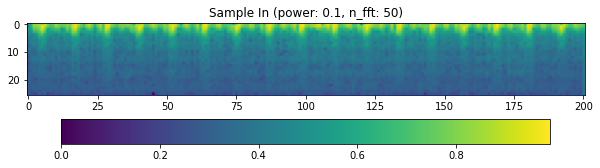

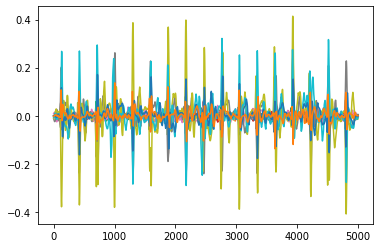

torch.Size([3, 12, 26, 201]) tensor(2.7738, grad_fn=<MaxBackward1>) tensor(0.)


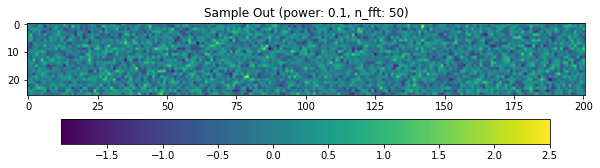

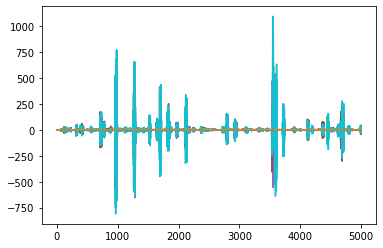

In [182]:
print(samp_in.shape, torch.max(samp_in), torch.min(samp_in))
plt.figure(figsize=(10, 3))

plt.title(f"Sample In (power: {power}, n_fft: {n_fft})")
plt.imshow(samp_in[0, 0, :,:].numpy())
plt.colorbar(orientation="horizontal")
plt.show()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    recon = torchaudio.transforms.GriffinLim(n_fft=n_fft, power=power, normalized=True)(samp_in)

plt.figure()
plt.plot(recon[0, :, :].T)
plt.show()

samp_out = dec(enc(samp_in))
samp_out = samp_out.view(-1, 12, 26, 201)

print(samp_out.shape, torch.max(samp_out), torch.min(samp_in))
plt.figure(figsize=(10, 3))

plt.title(f"Sample Out (power: {power}, n_fft: {n_fft})")
plt.imshow(samp_out[0, 0, :, :].detach().numpy())
plt.colorbar(orientation="horizontal")
plt.show()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    recon = torchaudio.transforms.GriffinLim(n_fft=n_fft, power=power, normalized=True)(samp_out.detach())

plt.figure()
plt.plot(recon[0, :, :].T)
plt.show()


## Investigating Dataset Outliers

In [199]:
ds = CinC2020(set_seq_len=5000, fs=500, clean_signal=True)
dl = DataLoader(ds, batch_size=1, shuffle=True)

count = 0
while True:
    p_signal, sampling_rate, age, sex, dx = next(iter(dl))
    _, _, num_channels = p_signal.shape
    z_batch, z_seq, z_channel = torch.nonzero(p_signal, as_tuple=True)
    non_zero_channels = torch.unique(z_channel)
    if len(non_zero_channels) != num_channels:
        print(p_signal)
        break
    else:
        print(f"count {count}", end="\r")
    count += 1

tensor([[[-0.0435, -0.0383,  0.0052,  ..., -0.0742, -0.0717, -0.0664],
         [-0.0514, -0.0437,  0.0078,  ..., -0.0826, -0.0700, -0.0781],
         [-0.0585, -0.0489,  0.0098,  ..., -0.0902, -0.0689, -0.0887],
         ...,
         [-0.0998, -0.0285,  0.0713,  ..., -0.0530, -0.0334,  0.0149],
         [-0.0950, -0.0340,  0.0610,  ..., -0.0547, -0.0357,  0.0102],
         [-0.0900, -0.0400,  0.0500,  ..., -0.0569, -0.0386,  0.0052]]])


torch.Size([1, 5000, 12])


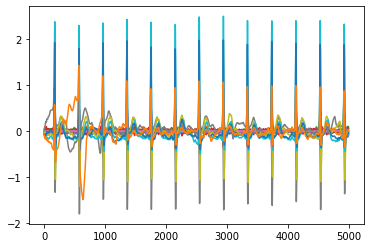

specgram.shape torch.Size([1, 12, 26, 201])
0 DescribeResult(nobs=5226, minmax=(0.17538035, 1.0288242), mean=0.4903087, variance=0.021765854, skewness=1.0705317258834839, kurtosis=0.5573676908047052)
1 DescribeResult(nobs=5226, minmax=(0.18263754, 1.0062423), mean=0.48427185, variance=0.023343557, skewness=1.1960796117782593, kurtosis=0.865672370857026)
2 DescribeResult(nobs=5226, minmax=(0.17538035, 1.0457437), mean=0.4727353, variance=0.02289433, skewness=1.207517385482788, kurtosis=1.0239022116247627)
3 DescribeResult(nobs=5226, minmax=(0.17933784, 0.99345905), mean=0.48419785, variance=0.022038423, skewness=1.1137514114379883, kurtosis=0.5940328562336581)
4 DescribeResult(nobs=5226, minmax=(0.19405025, 1.0256737), mean=0.47717604, variance=0.02139021, skewness=1.0995969772338867, kurtosis=0.6794491389753876)
5 DescribeResult(nobs=5226, minmax=(0.15267746, 1.0165168), mean=0.4659348, variance=0.022683747, skewness=1.2674511671066284, kurtosis=1.146404546081265)
6 DescribeResult(nobs

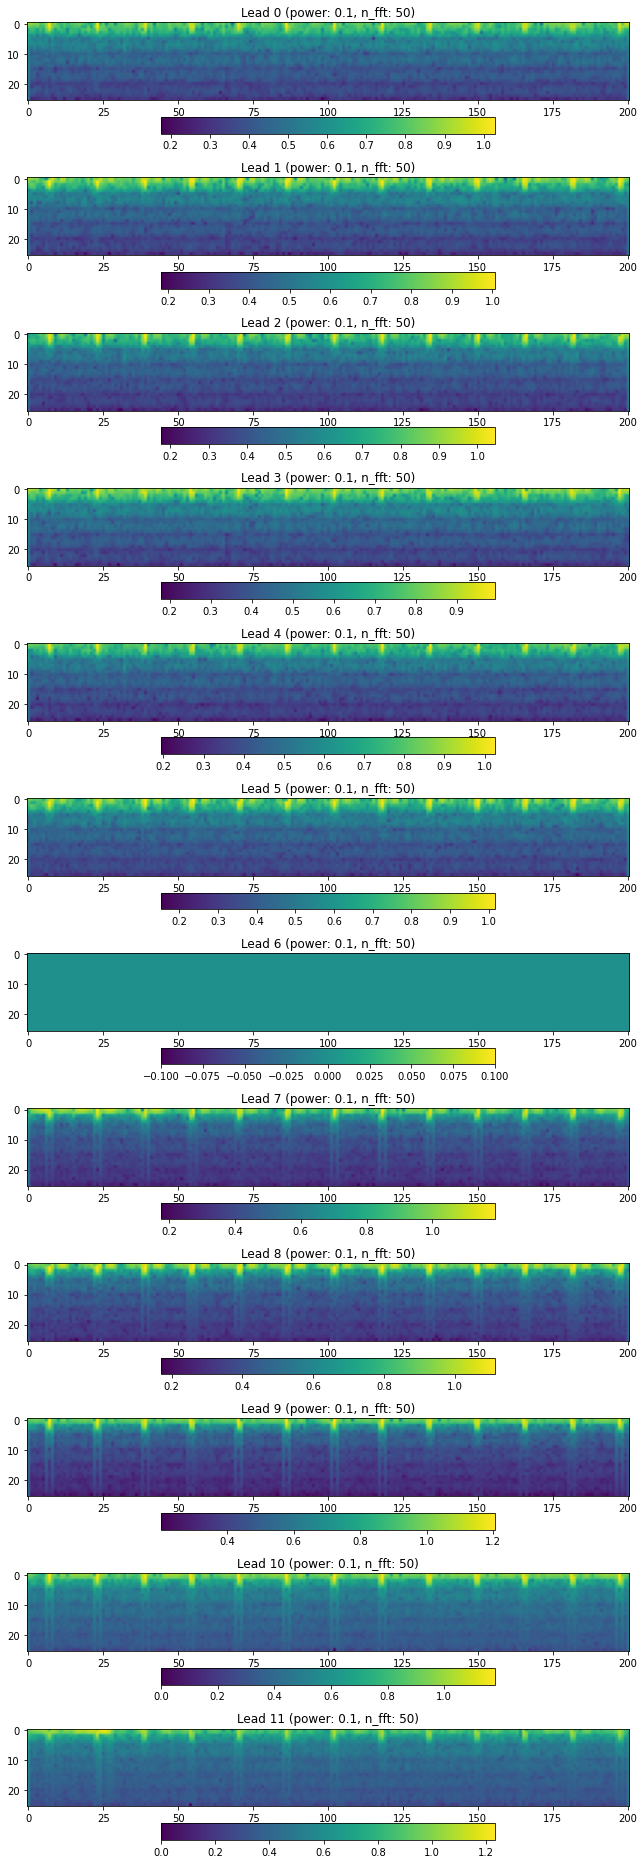

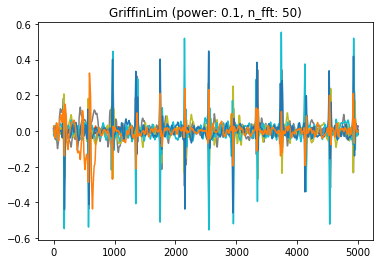

In [214]:
print(p_signal.shape)

plt.figure()
plt.plot(p_signal[0])
plt.show()

n_fft = 50

# power
power = 0.1

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    n = torchaudio.transforms.Spectrogram(
        n_fft = n_fft,
        power = power,
        normalized=True
    )
    specgram = n(torch.Tensor(torch.transpose(p_signal, 1, 2)))
    print("specgram.shape", specgram.shape)
    rn = torchaudio.transforms.GriffinLim(n_fft = n_fft, power = power)
    recon = rn(specgram)


fig, axs = plt.subplots(12, 1, figsize=(10, 26))
# plt.imshow(specgram[0,:,:].log2().numpy())
for i in range(12):
    axs[i].set_title(f"Lead {i} (power: {power}, n_fft: {n_fft})")
    pcm = axs[i].imshow(specgram[0,i,:,:].numpy())
    fig.colorbar(pcm, orientation="horizontal", ax=axs[i])
    print(i, scipy.stats.describe(specgram[0,i,:,:].numpy().flatten()))
#     axs[i].colorbar()
fig.tight_layout()
plt.show()

plt.figure()
plt.title(f"GriffinLim (power: {power}, n_fft: {n_fft})")
plt.plot(recon[0].T)
plt.show()

In [248]:
import torch.nn.functional as F

F.mse_loss(torch.Tensor([0.0, 0.0, 0.0]), torch.Tensor([0.3, 0.5, 0.6]))

n = torchaudio.transforms.Spectrogram(
    n_fft = 50,
    power = 1,
    normalized=True
)
any(torch.isnan(n(torch.zeros(1, 12, 5000))).flatten())

with open("nan_loss.npy", "rb") as f:
    x_recon = torch.Tensor(np.load(f))
    x_source = torch.Tensor(np.load(f))

# print(x_recon)
print(x_source[~torch.isnan(x_source)].shape)
print(x_recon[~torch.isnan(x_source)].shape)

torch.Size([57486])
torch.Size([57486])


## TorchAudio SPEECHCOMMANDS Dataset

In [ ]:
ds = torchaudio.datasets.SPEECHCOMMANDS("data", download=True)

In [ ]:
len(ds)

In [ ]:
waveform, sample_rate, utterance, speaker_id, utterance_id = ds[10]
waveform, sample_rate, utterance, speaker_id, utterance_id

In [ ]:
waveform.shape


In [ ]:
display(Audio(data=waveform, rate=sample_rate))

In [ ]:
f, t, Sxx =signal.spectrogram(waveform.view(-1), fs=sample_rate)
print(f.shape, t.shape, Sxx.shape)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
specgram = torchaudio.transforms.Spectrogram()(waveform)
plt.figure()
print(specgram.shape)
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap="gray")
plt.show()
plt.imshow(specgram[0,:,:].numpy(), cmap="gray")